In [1]:
# Matrix Manipulation Packages/Libraries 
import pandas as pd
import numpy as np

# Statistical Analysis & Machine Learning Packages/Libraries 
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE # <--- Recursive Feature Eliminator
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import pearsonr # <--- Pearson Correlation
from sklearn.feature_selection import SelectKBest, chi2 # <--- Chi-Squared Test
from sklearn.feature_selection import SelectKBest, f_classif # <--- Analysis of Variance
from sklearn.ensemble import RandomForestClassifier # <--- Random Forest Regressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.svm import SVC # <--  Support Vector Machine
import xgboost as xgb # <--  XGBoost
from sklearn.metrics import mean_squared_error
import sklearn.neighbors # <--- k-Nearest Neighbors
from sklearn.feature_selection import mutual_info_classif
from sklearn.neural_network import MLPClassifier # <--- Multi-Layer Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint
import sklearn.ensemble # <--- Soft Voting Machine
from sklearn.metrics import confusion_matrix

# Data Visualization Packages/Libraries 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.tree import plot_tree

# Miscellaneous Packages/Libraries 
import warnings
from biothings_client import get_client
from sklearn.exceptions import ConvergenceWarning

# Hardcoded Values
random_state = 42 # <--- Random State
test_size = 0.3 # <--- Test/Train Split

kfold = KFold(n_splits = 5, shuffle = True, random_state = random_state) # <--- KFold
warnings.filterwarnings("ignore", category = ConvergenceWarning) # <--- Supress Warnings

In [2]:
def data_preprocessing (cases_file, controls_file, clinical_file): 
    cases = pd.read_csv(cases_file);
    controls = pd.read_csv(controls_file);
    cases.fillna('Other', inplace = True);
    controls.fillna('Other', inplace = True);
    df = pd.concat([cases, controls])
    df = df[['SID','Gender','Race','Age','Type','ID','gene_id','length', 'effective_length','TPM', 'FPKM']];
    df = preprocessing_helper(df, clinical_file);
    df = df.fillna(0)
    return df


def preprocessing_helper (dataframe, clinical_file):
    df = pd.pivot_table(dataframe, index = "SID", columns = 'gene_id', values = 'TPM').reset_index()
    df = df.rename(columns = {'SID': 'ID'})
    clinical_data = pd.read_csv(clinical_file)
    clinical_data = clinical_data.drop('Unnamed: 0', axis = 1)
    df = df.merge(clinical_data, how = 'left')
    unprocessed_df = df
    df.loc[df['Race'] == 'White ', 'Race'] = 'White'
    df.loc[df['Race'] == 'Other', 'Race'] = 6
    df.loc[df['Race'] == 'White', 'Race'] = 1
    df.loc[df['Race'] == 'Black', 'Race'] = 2
    df.loc[df['Race'] == 'Asian', 'Race'] = 19
    df.loc[df['Race'] == 'Decline to Answer', 'Race'] = 7
    df.loc[df['Gender'] == 'Other', 'Gender'] = 999
    df.loc[df['Gender'] == 'Female', 'Gender'] = 0
    df.loc[df['Gender'] == 'Male', 'Gender'] = 1
    df.drop(df.index[df['Age'] == 'Other'],inplace = True)
    df.loc[df['Type'] == 'Control', 'Type'] = 1
    df.loc[df['Type'] == 'Case', 'Type'] = 0
    percentage_cut = 20.0
    minimum_count =  int(((100 - percentage_cut) / 100) * df.shape[0] + 1)
    df = df.dropna(axis = 1, thresh = minimum_count)
    print("Original Features: ", len(unprocessed_df.columns))
    print("Preprocessed Features: ", len(df.columns))
    return df

df = data_preprocessing('GeneAI_TPM_10_CVD_Cohort_C1_09222022.csv',
                        'GeneAI_TPM_10_Control_Cohort_C1_10032022.csv',
                        'gene_cohort_clinical_data.csv')

Original Features:  9012
Preprocessed Features:  753


In [3]:
# Feature Selection 
y = df['Type'] # <--- Target (Case/Control)
x = df.drop(['Type', 'ID'], axis = 1) # <--- Features (Genomic/Clinical)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size, random_state = random_state) # <-- Test/Train

x_transformed = np.log1p(x_train) # <--- Normalization 

In [4]:
# Recursive Feature Elimination
rfe = RFE(estimator = DecisionTreeClassifier(), n_features_to_select = 1) # <--- Initialize RFE
rfe.fit(x_train, y_train) # <--- Fit RFE

rfe_scores = pd.DataFrame(rfe.ranking_) # <--- Scores
rfe_features = pd.DataFrame(x_train.columns) # <--- Features

rfe_df = pd.concat([rfe_features, rfe_scores], axis = 1) # <-- Merge RFE Scores and Labels
rfe_df.columns = ['Ensembl ID', 'RFE Score'] # <--- Create Table 
rfe_df_sorted = rfe_df.sort_values(by=['RFE Score']) # <--- Sort Table
rfe_df_significant = rfe_df_sorted[rfe_df_sorted['RFE Score'] <= int((df.shape[1] - 2) * .10)] # <--- Significance Filter 

rfe_df_significant # <--- Display Table

Ensembl ID  RFE Score
739  ENSG00000256618          1
750              Age          2
749             Race          3
748           Gender          4
747  ENSG00000269858          5
..               ...        ...
680  ENSG00000214212         71
679  ENSG00000214026         72
678  ENSG00000213934         73
677  ENSG00000213860         74
676  ENSG00000213741         75

[75 rows x 2 columns]

In [5]:
# Pearson Correlation
person_correlations = [pearsonr(x[column], y) for column in x.columns] # <--- Calculate Pearson Correlation 

pearson_df = pd.DataFrame(person_correlations, columns=['Correlation Coefficient', 'p-value'], # <--- Generate p-values
                          index = x.columns).reset_index().rename(columns={'index': 'Ensembl ID'}) # <--- Create Table 

pearson_df['Absolute Correlation Coefficient'] = np.abs(pearson_df['Correlation Coefficient']) # <--- Absolute Value

pearson_df_sorted = pearson_df.sort_values(by='Absolute Correlation Coefficient', 
                                    ascending = False).drop('Absolute Correlation Coefficient', axis = 1) # <--- Sort Table

pearson_df_significant = pearson_df_sorted[pearson_df_sorted['p-value'] < 0.05] # <--- Significance Filter 

pearson_df_significant # <--- Display Table

Ensembl ID  Correlation Coefficient       p-value
343  ENSG00000143384                 0.728992  3.864547e-13
295  ENSG00000135821                 0.706694  4.021985e-12
330  ENSG00000142347                 0.700407  7.488174e-12
139  ENSG00000108654                 0.694624  1.308059e-11
94   ENSG00000102879                 0.693298  1.483833e-11
..               ...                      ...           ...
717  ENSG00000240065                 0.233979  4.790793e-02
82   ENSG00000100568                 0.233065  4.881140e-02
746  ENSG00000268903                 0.232284  4.959442e-02
494  ENSG00000170275                 0.232251  4.962756e-02
305  ENSG00000136908                 0.232031  4.985032e-02

[355 rows x 3 columns]

In [6]:
# Chi-Squared Test
chisq_features = SelectKBest(score_func = chi2, k = 10) # <--- Select 10 Features
chisq_fit = chisq_features.fit(x_train, y_train) # <--- Fit Chi-Squared

chisq_scores = pd.DataFrame(chisq_fit.scores_) # <--- Scores
chisq_pvalues = pd.DataFrame(chisq_fit.pvalues_) # <--- p-values
chisq_labels = pd.DataFrame(x_train.columns) # <--- Features 

chisq_df = pd.concat([chisq_labels, chisq_scores, chisq_pvalues], axis = 1)
chisq_df.columns = ['Ensembl ID', 'Chi-Square Statistic', 'p-value'] # <--- Create Table 
chisq_df_sorted = chisq_df.sort_values(by=['Chi-Square Statistic'], ascending = False) # <--- Sort Table
chisq_df_significant = chisq_df_sorted[chisq_df_sorted['p-value'] < 0.05] # <--- Significance Filter 

chisq_df_significant # <--- Display Table

Ensembl ID  Chi-Square Statistic   p-value
588  ENSG00000188536         272938.184348  0.000000
661  ENSG00000206172         249778.751157  0.000000
729  ENSG00000244734         123869.836746  0.000000
666  ENSG00000211592          34627.685480  0.000000
39   ENSG00000075624          23617.826150  0.000000
..               ...                   ...       ...
305  ENSG00000136908              4.168734  0.041177
586  ENSG00000188243              4.105952  0.042733
573  ENSG00000185262              3.993936  0.045664
397  ENSG00000158578              3.886057  0.048689
504  ENSG00000171700              3.849383  0.049764

[681 rows x 3 columns]

In [7]:
# Analysis of Variance
anova_features = SelectKBest(score_func = f_classif, k = 10).fit(x_train, y_train) # <--- Select 10 Features

anova_scores = pd.DataFrame(anova_features.scores_, columns=['F-Statistic']) # <--- Scores
anova_pvalues = pd.DataFrame(anova_features.pvalues_, columns=['p-value']) # <--- p-values
anova_labels = pd.DataFrame(x_train.columns, columns=['Ensembl ID']) # Features

anova_df = pd.concat([anova_labels, anova_scores, anova_pvalues], axis = 1) # <--- Create Table
anova_df_sorted = anova_df.sort_values('F-Statistic', ascending = False) # <--- Sort Table
anova_df_significant = anova_df_sorted[anova_df_sorted['p-value'] < 0.05] # <--- Significance Filter 

anova_df_significant # <--- Display Table

Ensembl ID  F-Statistic       p-value
343  ENSG00000143384    65.331203  1.651590e-10
94   ENSG00000102879    60.546244  4.722949e-10
69   ENSG00000099622    58.687519  7.195466e-10
488  ENSG00000169564    55.124980  1.647595e-09
330  ENSG00000142347    54.947093  1.718501e-09
..               ...          ...           ...
209  ENSG00000122694     4.103353  4.837701e-02
172  ENSG00000113811     4.061078  4.950114e-02
120  ENSG00000105583     4.060570  4.951483e-02
472  ENSG00000167705     4.052280  4.973865e-02
279  ENSG00000131981     4.047148  4.987778e-02

[318 rows x 3 columns]

In [8]:
# Complete Merged Table
merged_df = (anova_df_sorted.merge(chisq_df_sorted, on='Ensembl ID', how='outer')
                             .merge(pearson_df_sorted, on='Ensembl ID', how='outer')
                             .merge(rfe_df_sorted, on='Ensembl ID', how='outer'))

merged_df.columns = ['Ensembl ID', 
                     'F-Statistic', 'p-value (ANOVA)', 
                     'Chi-Square Statistic', 'p-value (Chi-Squared Test)', 
                     'Correlation Coefficient', 'p-value (Pearson Correlation)',
                     'RFE Score']

#merged_df.to_csv('Table_S02_Biomarker-Selection.csv', index = None)

In [9]:
# Supported Biomarkers

biomarkers_df = anova_df_sorted.merge(chisq_df_sorted, on='Ensembl ID').merge(pearson_df_sorted, on='Ensembl ID')

biomarkers_df.columns = ['Ensembl ID', 
                         'F-Statistic', 'p-value (ANOVA)', 
                         'Chi-Square Statistic', 'p-value (Chi-Squared Test)', 
                         'Correlation Coefficient', 'p-value (Pearson Correlation)'] # <--- Create Biomarkers Table

statistical_biomarkers_df = biomarkers_df[(biomarkers_df['p-value (ANOVA)'] < 0.05) 
                                          & (biomarkers_df['p-value (Chi-Squared Test)'] < 0.05) 
                                          & (biomarkers_df['p-value (Pearson Correlation)'] < 0.05)] # <-- Filter 0.05 p-value

rfe_quantile = int((df.shape[1] - 2) * .10) # <-- Top 10% Features (Columns wo/ Type & ID)

rfe_biomarkers_df = statistical_biomarkers_df.merge(rfe_df_sorted, on='Ensembl ID')
significant_biomarkers_df = rfe_biomarkers_df[rfe_biomarkers_df['RFE Score'] <= rfe_quantile] # <--- Significant Biomarkers

significant_biomarkers_list = significant_biomarkers_df['Ensembl ID'].values # <-- Ensembl ID for ML/AI Analysis

significant_biomarkers_df # <--- Display Table 

Ensembl ID  F-Statistic  p-value (ANOVA)  Chi-Square Statistic   
104  ENSG00000266422    18.461681         0.000084           6099.039146  \
110  ENSG00000242574    17.331401         0.000130           1182.198479   
126  ENSG00000256618    15.446228         0.000272            425.057043   
134  ENSG00000265150    14.623182         0.000378           5570.193207   
145  ENSG00000234745    13.250337         0.000666          21800.548163   
153  ENSG00000241553    12.825211         0.000796            967.241151   
160  ENSG00000256514    12.516301         0.000907             97.158556   
161  ENSG00000231389    12.508201         0.000910           2762.649364   
179  ENSG00000239998    11.287611         0.001536            467.715261   
187  ENSG00000234741    10.144119         0.002544            250.754169   
189  ENSG00000247596    10.131465         0.002558            169.360342   
201  ENSG00000215845     9.419225         0.003527            324.041848   
203  ENSG00000269858     9.331682         0.003670            199.903685   
252  ENSG00000233276     6.823535         0.011974            286.051535   
259  ENSG00000245910     6.440925         0.014453            146.302324   
274  ENSG00000227097     5.590552         0.022150           3696.999979   
283  ENSG00000254999     5.208093         0.026955            105.501496   
301  ENSG00000260592     4.491244         0.039268             45.016687   

     p-value (Chi-Squared Test)  Correlation Coefficient   
104                0.000000e+00                 0.573205  \
110               4.509106e-259                 0.468663   
126                1.935248e-94                -0.498578   
134                0.000000e+00                 0.501749   
145                0.000000e+00                 0.444308   
153               2.371251e-212                 0.437526   
160                6.399216e-23                -0.422351   
161                0.000000e+00                 0.415750   
179               1.006809e-103                 0.437466   
187                1.778382e-56                 0.381093   
189                1.020647e-38                 0.378112   
201                1.907727e-72                 0.318412   
203                2.192047e-45                 0.393315   
252                3.605049e-64                -0.381306   
259                1.114934e-33                 0.290125   
274                0.000000e+00                 0.256310   
283                9.482631e-25                 0.271572   
301                1.953626e-11                 0.314078   

     p-value (Pearson Correlation)  RFE Score  
104                   1.422727e-07          8  
110                   3.295239e-05         27  
126                   8.304967e-06          1  
134                   7.121012e-06         10  
145                   9.238810e-05         41  
153                   1.214456e-04         29  
160                   2.194047e-04         13  
161                   2.813561e-04         46  
179                   1.217368e-04         35  
187                   9.577038e-04         42  
189                   1.057660e-03         20  
201                   6.413323e-03         66  
203                   6.311975e-04          5  
252                   9.509177e-04         43  
259                   1.343124e-02         21  
274                   2.976190e-02         53  
283                   2.102230e-02         14  
301                   7.215015e-03         11

In [10]:
# ML/AI Analysis
y = df['Type'] # <--- Target (Case/Control)
x = df[significant_biomarkers_list] # <--- Features (Significant Biomarkers)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size, random_state = random_state) # <--  Test/Train

In [11]:
# Random Forest Classifier (with Hyperparameter Tuning)
rf = RandomForestClassifier(random_state = 42) # <--- Initialize RF 
rf.fit(x_train, y_train) # <--- Fit RF

rf_parameter_grid = { 
    'max_features': np.arange(1, x_train.shape[1] + 1),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.concatenate([np.arange(1, 11), [100, 150]])
} # <--- Generate Parameter Grid

rf_best = GridSearchCV(
    rf, param_grid = rf_parameter_grid, cv = kfold,
    scoring = 'accuracy', n_jobs = -1, verbose = 0
) # <--- Hyperparameter Tuning 

rf_best.fit(x_train, y_train) # <--- Fit GridSearchCV
rf_best = rf_best.best_estimator_ # <--- Assign Best Estimator 

y_predict = rf_best.predict(x_test) # <--- Predict Target
rf_accuracy = accuracy_score(y_test, y_predict) # <--- Calculate Accuracy

y_probs = rf_best.predict_proba(x_test)
y_probs = y_probs[:, 1] # <--- Predict Positives Classes

rf_roc_auc = roc_auc_score(y_test, y_probs) # <--- Receiver Operating Characteristic Curve
rf_F1 = f1_score(y_test, y_predict, average = 'weighted') # <--- Weigthed-Average F1 Score

print('Accuracy: ', rf_accuracy)
print('ROC-AUC: ', rf_roc_auc)
print('Weighted-Average F1 Score: ', rf_F1)

Accuracy:  0.9545454545454546
ROC-AUC:  0.9513888888888888
Weighted-Average F1 Score:  0.9564213564213564


In [12]:
# Support Vector Machine (with Hyperparameter Tuning)
svmc = SVC(kernel = 'linear', probability = True) # <--- Initialize SVM
svmc.fit(x_train, y_train) # <--- Fit SVM

svmc_parameter_grid = {
    "kernel": ['linear', 'rbf'],
    'gamma': [0.001, 0.01, 0.1, 1, 10],
    'C': [0.01, 0.1, 1, 10, 50, 100, 500, 1000, 5000, 10000]
} # <--- Generate Parameter Grid

svmc_best = GridSearchCV(
    svmc, param_grid = svmc_parameter_grid, cv = kfold, 
    scoring = 'accuracy', n_jobs = -1, verbose = 0
) # <--- Hyperparameter Tuning 

svmc_best.fit(x_train, y_train) # <--- Fit GridSearchCV
svmc_best = svmc_best.best_estimator_ # <--- Assign Best Estimator 

y_predict = svmc_best.predict(x_test) # <--- Predict Target
svmc_accuracy = accuracy_score(y_test, y_predict) # <--- Calculate Accuracy

y_probs = svmc_best.predict_proba(x_test)
y_probs = y_probs[:, 1] # <--- Predict Positives Classes

svmc_roc_auc = roc_auc_score(y_test, y_probs) # <--- Receiver Operating Characteristic Curve
svmc_F1 = f1_score(y_test, y_predict, average = 'weighted') # <--- Weigthed-Average F1 Score

print('Accuracy: ', svmc_accuracy)
print('ROC-AUC: ', svmc_roc_auc)
print('Weighted-Average F1 Score: ', svmc_F1)

Accuracy:  0.9090909090909091
ROC-AUC:  0.986111111111111
Weighted-Average F1 Score:  0.9090909090909091


In [13]:
# Extreme Gradiant Boosting (with Hyperparameter Tuning)
xgb_model = xgb.XGBClassifier(objective = "reg:squarederror") # <--- Initialize XGBoost 
xgb_model.fit(x_train, y_train) # <--- Fit XGBoost

n_estimators_range = [int(x) for x in np.linspace(100, 500, 5)]
max_depth_range = [int(x) for x in np.linspace(3, 9, 4)]
gamma_range = [0.01, 0.1]
learning_rate_range = [0.001, 0.01, 0.1, 1] # <--- Parameters from Samples, Standard Use

xgb_parameter_grid = {
    "n_estimators": n_estimators_range,
    "max_depth": max_depth_range,
    "gamma": gamma_range,
    "learning_rate": learning_rate_range
} # <--- Generate Parameter Grid

xgb_best = GridSearchCV(
    estimator = xgb_model, param_grid = xgb_parameter_grid, cv = kfold, refit = "r2",
    scoring = 'accuracy', n_jobs = -1, verbose = 0
) # <--- Hyperparameter Tuning 

xgb_best.fit(x_train, y_train) # <--- Fit GridSearchCV
xgb_best = xgb_best.best_estimator_ # <--- Assign Best Estimator 

y_predict = xgb_best.predict(x_test) # <--- Predict Target
xgb_accuracy = accuracy_score(y_test, y_predict) # <--- Calculate Accuracy

y_probs = xgb_best.predict_proba(x_test)
y_probs = y_probs[:, 1] # <--- Predict Positives Classes

xgb_roc_auc = roc_auc_score(y_test, y_probs) # <--- Receiver Operating Characteristic Curve
xgb_F1 = f1_score(y_test, y_predict, average = 'weighted') # <--- Weigthed-Average F1 Score

print('Accuracy: ', xgb_accuracy)
print('ROC-AUC: ', xgb_roc_auc)
print('Weighted-Average F1 Score: ', xgb_F1)

Accuracy:  0.9090909090909091
ROC-AUC:  0.9444444444444444
Weighted-Average F1 Score:  0.9155080213903743


In [14]:
# k-Nearest Neighbors (with Hyperparameter Tuning)
knn_classifier = sklearn.neighbors.KNeighborsClassifier() # <--- Initialize kNN
knn_model = knn_classifier.fit(x_train, y_train)  # <--- Fit kNN

n_samples = len(x_train) 
max_neighbors = min(n_samples - 1, 30) 
leaf_size = list(range(1, 50)) 
n_neighbors = list(range(1, max_neighbors + 1)) # <--- Parameters from Samples, Standard Use
p = [1, 2] # <--- Manhattan, Euclidean Distance Metrics

knn_hyperparameters = dict(leaf_size = leaf_size, n_neighbors = n_neighbors, p = p) # <--- Hyperparametrs Dictionary

knn_best = GridSearchCV(knn_model, knn_hyperparameters, cv = kfold) # <--- Initialize GridSearchCV
knn_best = knn_best.fit(x_train, y_train) # <--- Fit GridSearchCV

y_predict = knn_best.predict(x_test) # <--- Predict Target
knn_accuracy = accuracy_score(y_test, y_predict) # <--- Calculate Accuracy

y_probs = knn_best.predict_proba(x_test)
y_probs = y_probs[:, 1] # <--- Predict Positives Classes

knn_roc_auc = roc_auc_score(y_test, y_probs) # <--- Receiver Operating Characteristic Curve
knn_F1 = f1_score(y_test, y_predict, average = 'weighted') # <--- Weigthed-Average F1 Score

print('Accuracy: ', knn_accuracy)
print('ROC-AUC: ', knn_roc_auc)
print('Weighted-Average F1 Score: ', knn_F1)

Accuracy:  0.9090909090909091
ROC-AUC:  0.8472222222222222
Weighted-Average F1 Score:  0.9090909090909091


In [15]:
# Soft Voting Classifier
classifiers = [
    ('rf', rf_best),
    ('svmc', svmc_best),
    ('xgb', xgb_best),
    ('knn', knn_best)
] # <-- Merge ML/AI Methods

soft_voting_classifier = sklearn.ensemble.VotingClassifier(classifiers, voting = 'soft') # <--- Initialize Soft Voting
soft_voting_classifier.fit(x_train, y_train) # <--- Fit Soft Voting

y_predict = soft_voting_classifier.predict(x_test) # <--- Predict Target
soft_voting_classifier_accuracy = accuracy_score(y_test, y_predict) # <--- Calculate Accuracy

y_probs = soft_voting_classifier.predict_proba(x_test)
y_probs = y_probs[:, 1] # <--- Predict Positives Classes

soft_voting_classifier_roc_auc = roc_auc_score(y_test, y_probs) # <--- Receiver Operating Characteristic Curve
soft_voting_classifier_F1 = f1_score(y_test, y_predict, average = 'weighted') # <--- Weigthed-Average F1 Score

print('Accuracy: ', soft_voting_classifier_accuracy)
print('ROC-AUC: ', soft_voting_classifier_roc_auc)
print('Weighted-Average F1 Score: ', soft_voting_classifier_F1)

Accuracy:  0.9090909090909091
ROC-AUC:  0.9722222222222222
Weighted-Average F1 Score:  0.9090909090909091


<Axes: xlabel='Age', ylabel='Frequency'>

<Figure size 640x480 with 0 Axes>

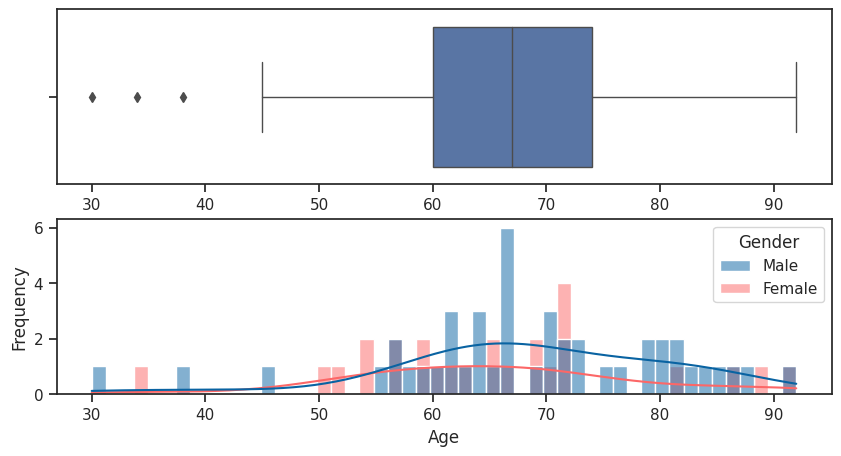

In [16]:
# Figure). Exploratory Analysis
working_dataset = df.loc[df['Age'] != 0]
working_dataset.loc[:, 'Gender'] = working_dataset['Gender'].replace({1: 'Male', 0: 'Female'})
plt.figure()
sns.set(rc={"figure.figsize":(10, 5)})
sns.set_style("whitegrid")
sns.set_style("ticks")

f, (ax_box, ax_hist) = plt.subplots(2, sharex=False)
plt.gca().set(xlabel= "Age" ,ylabel='Frequency')
sns.boxplot(working_dataset, x= "Age", ax= ax_box , linewidth= 1.0)
colors = {'Male': '#0963A2', 'Female': '#FC6767'}
sns.histplot(working_dataset, x='Age', hue='Gender', bins=50, kde=True, palette=colors, ax=ax_hist)

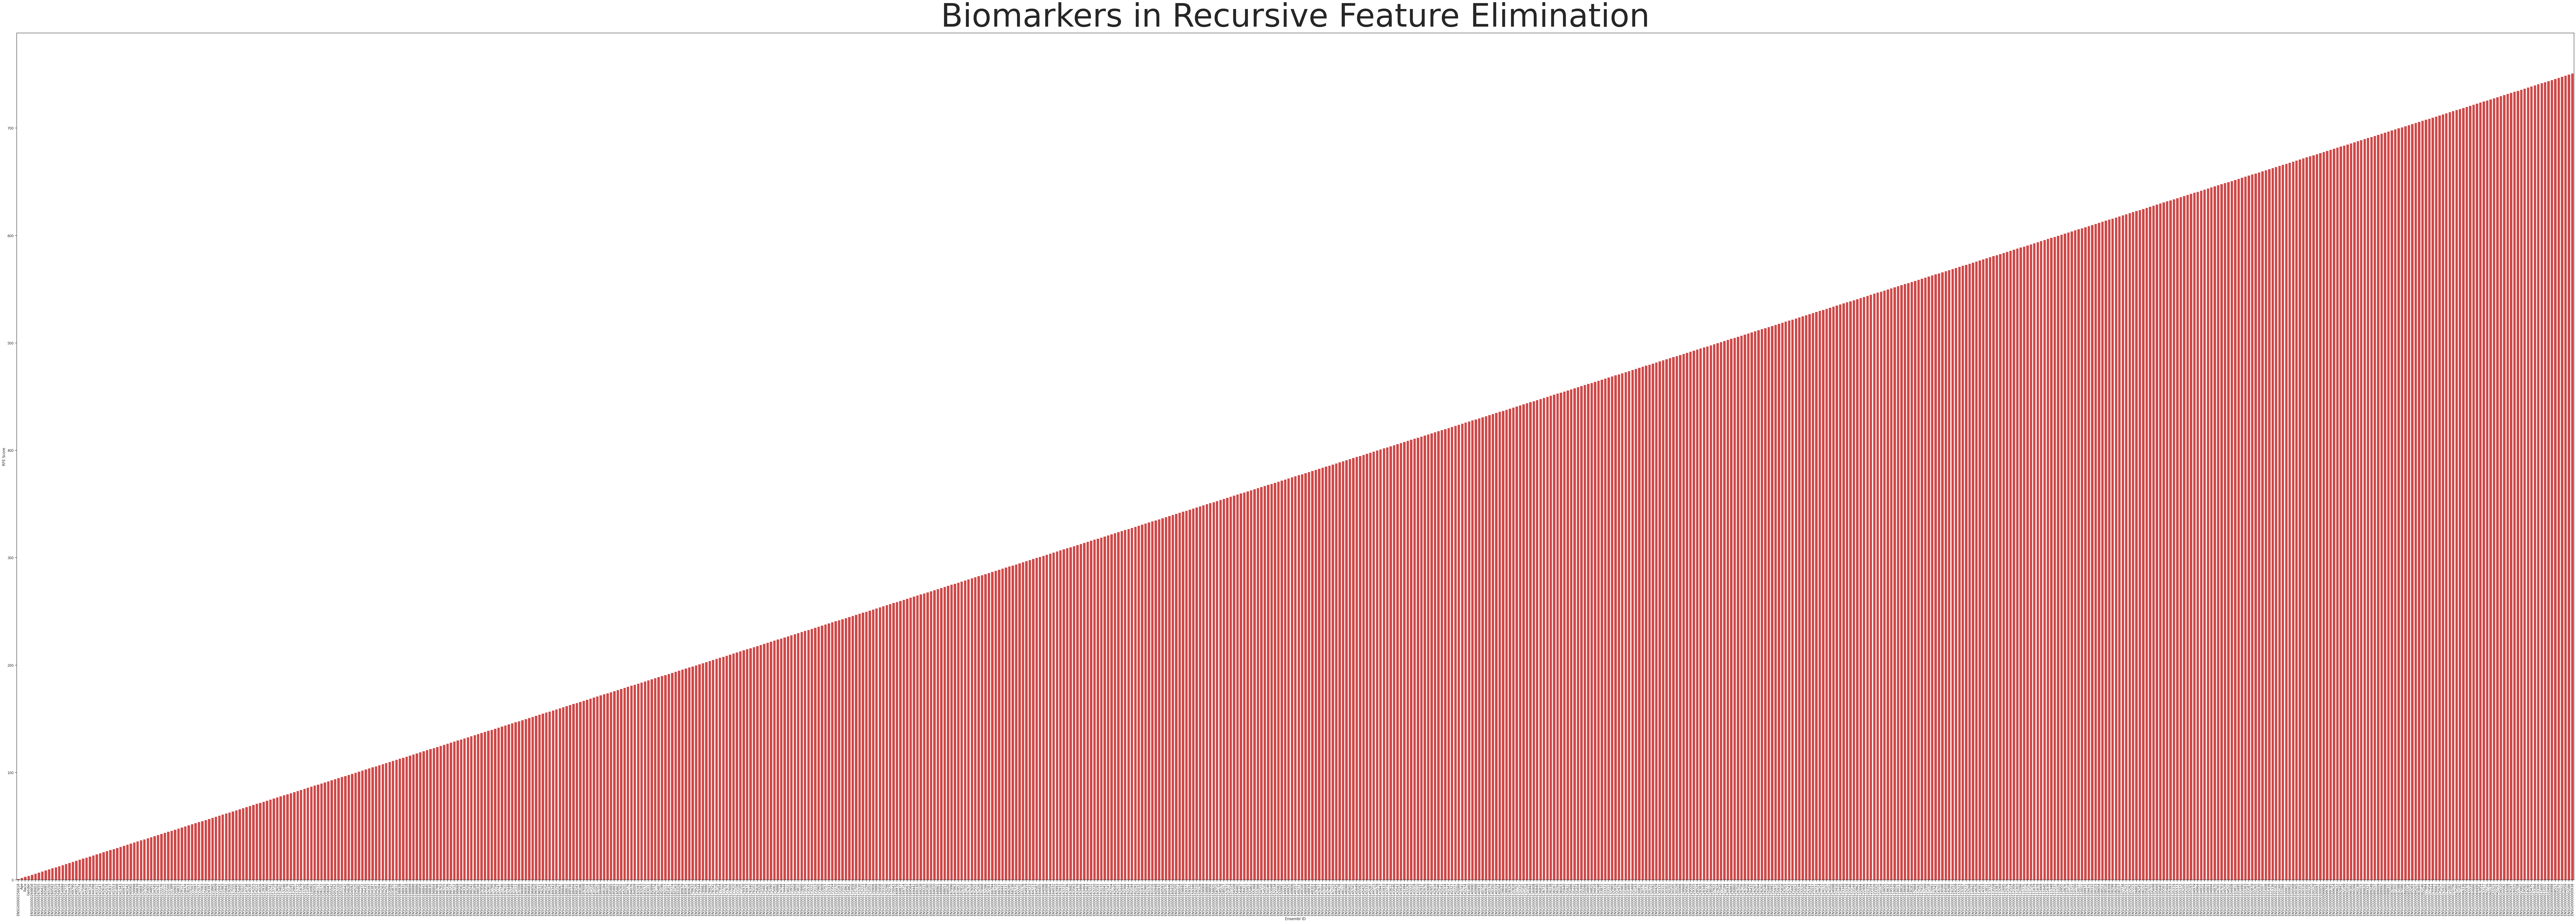

In [17]:
# Figure). Recursive Feature Elimination 
sns.set_style("whitegrid")
sns.set_style("ticks") # <--- Seaborn Settings

rfe_figure = rfe_df_sorted # <--- Figure Information

plt.figure(figsize = (150, 50)) # <--- Figure Size 
pearson_plot = sns.barplot(data = rfe_figure, x = "Ensembl ID", y = "RFE Score", color = "#E63131") # <--- Color
plt.xticks(rotation = 90) # <--- Vertical Features
plt.title("Biomarkers in Recursive Feature Elimination", fontsize = 105) # <--- Title
plt.show() # <--- Display Figure

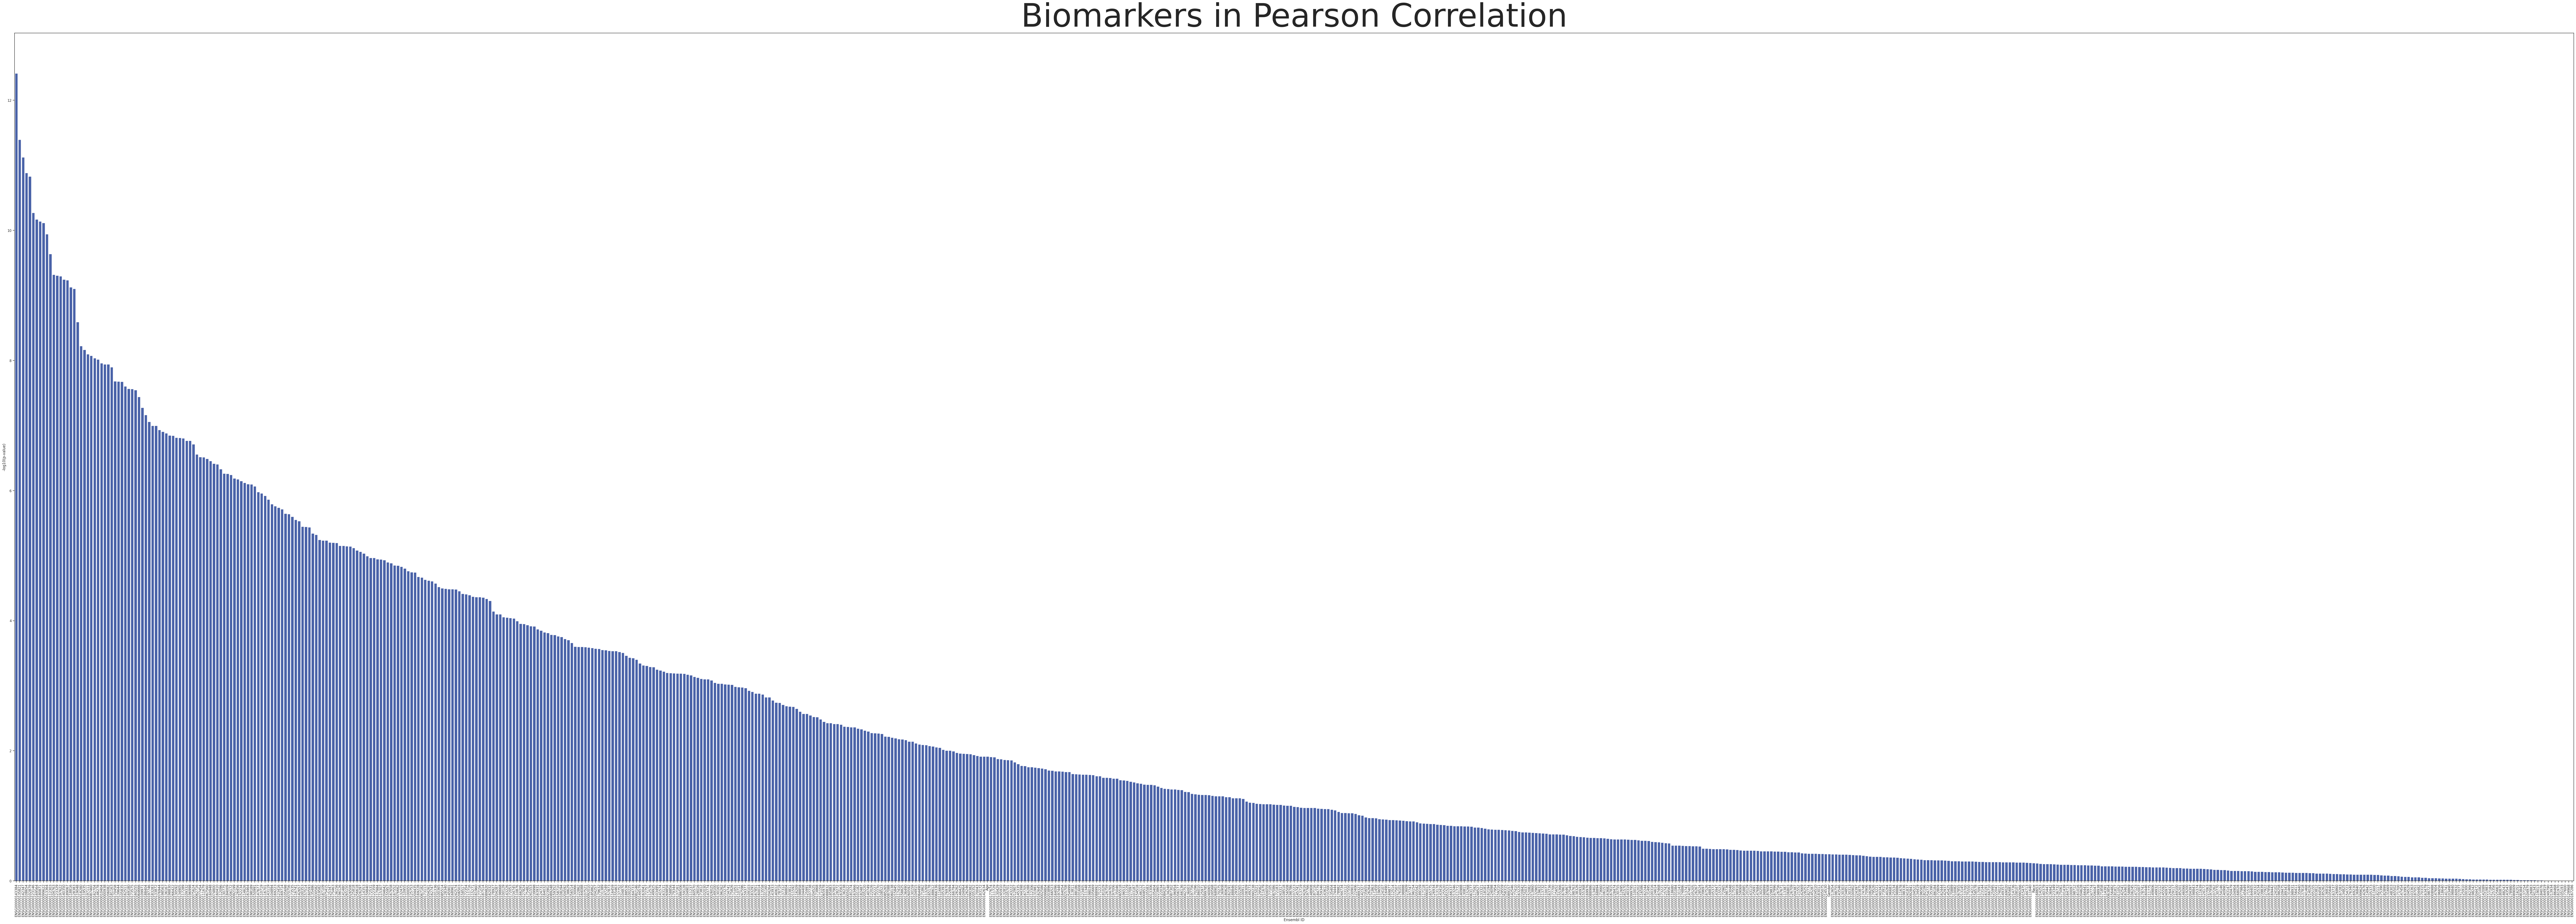

In [18]:
# Figure). Pearson Correlation
sns.set_style("whitegrid")
sns.set_style("ticks") # <--- Seaborn Settings

pearson_figure = pearson_df_sorted # <--- Figure Information
pearson_figure['-log10(p-value)'] = -np.log10(pearson_figure['p-value']) # <--- Normalize p-values

plt.figure(figsize = (150, 50)) # <--- Figure Size 
pearson_plot = sns.barplot(data = pearson_figure, x = "Ensembl ID", y = "-log10(p-value)", color = "#395BB8") # <--- Color
plt.xticks(rotation=90) # <--- Vertical Features
plt.title("Biomarkers in Pearson Correlation", fontsize = 105) # <--- Title
plt.show() # <--- Display Figure

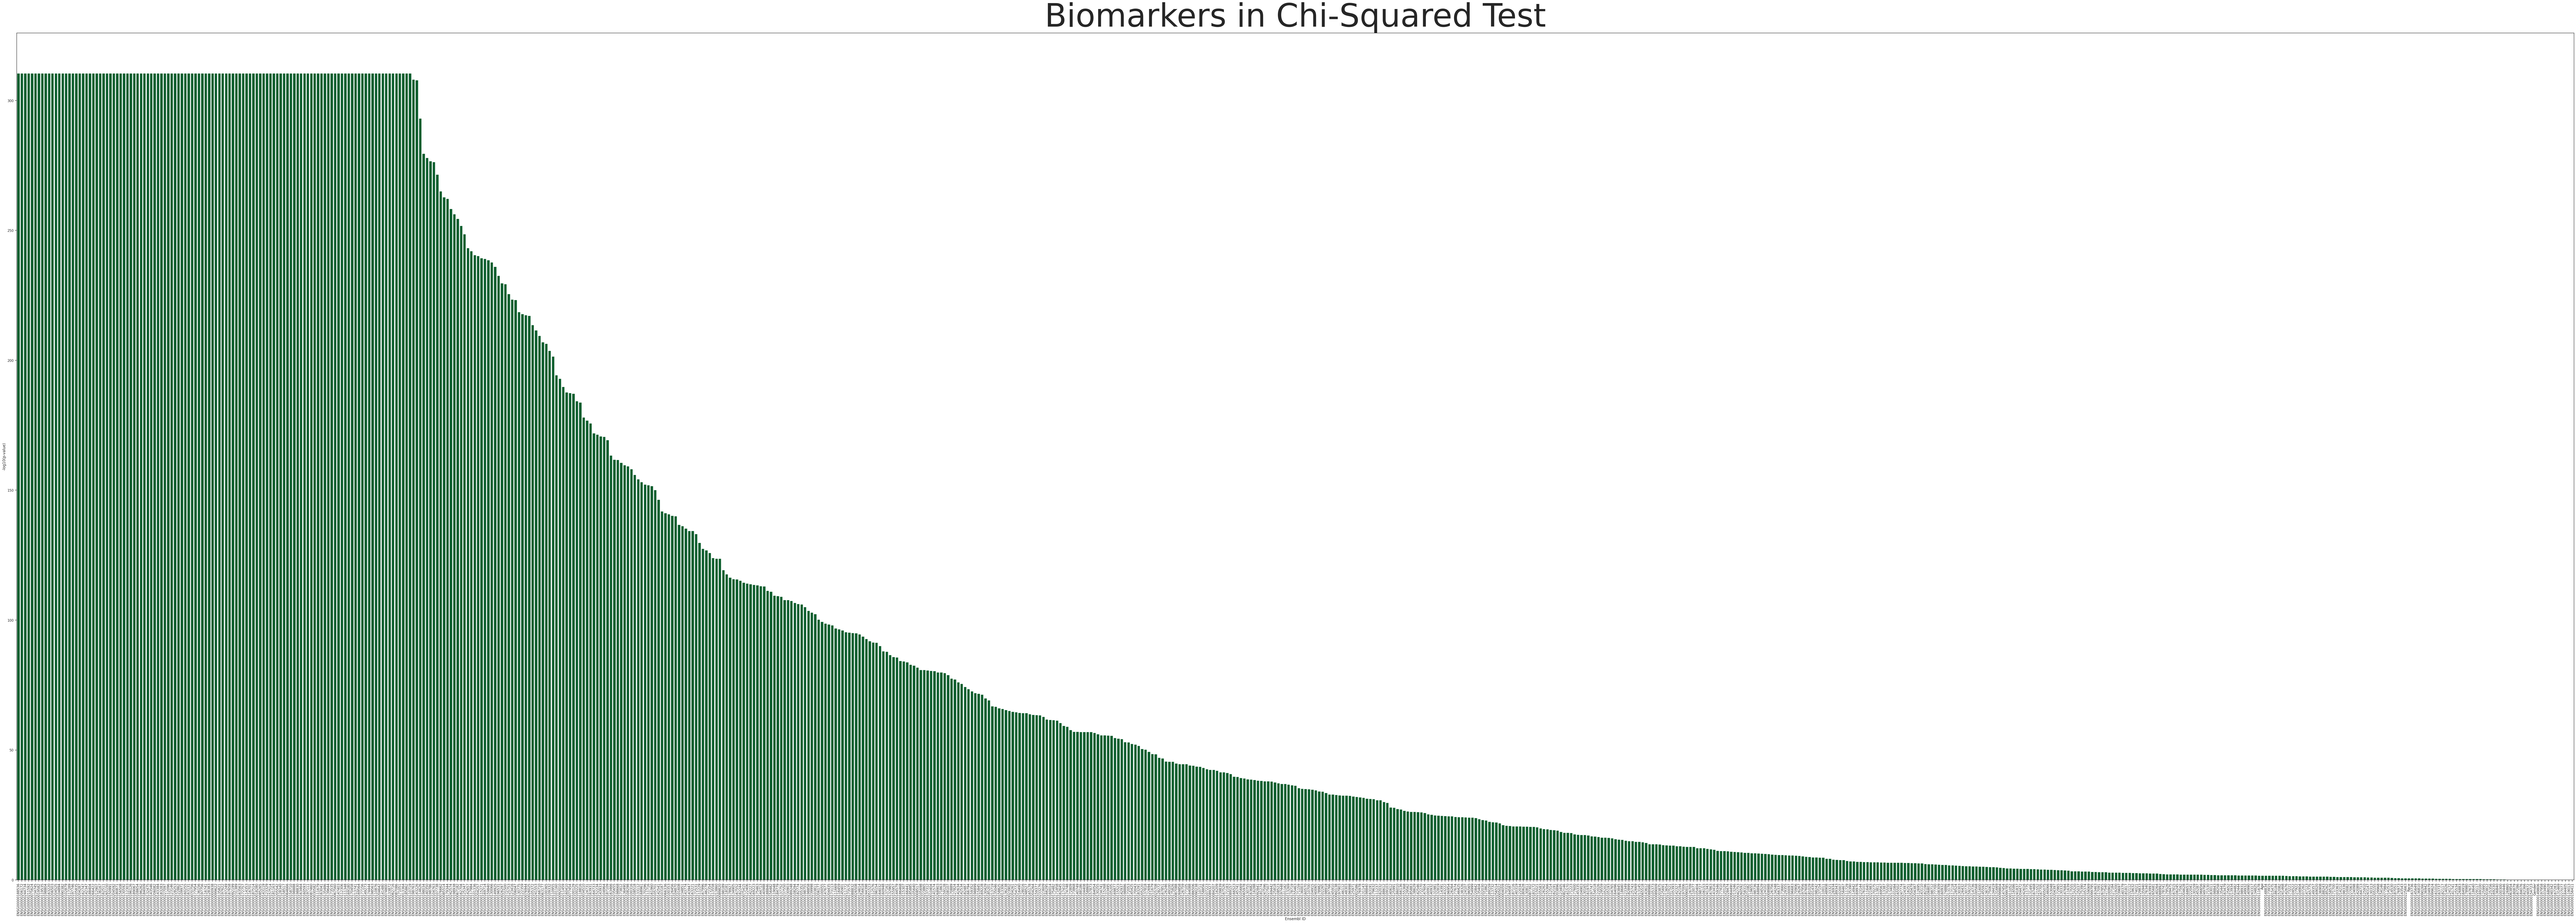

In [19]:
# Figure). Chi-Squared Test
sns.set_style("whitegrid")
sns.set_style("ticks") # <--- Seaborn Settings

chisq_figure = chisq_df_sorted # <--- Figure Information
minimum_value = chisq_figure.loc[chisq_figure['p-value'] > 0, 'p-value'].min()
chisq_figure.loc[chisq_figure['p-value'] == 0, 'p-value'] = minimum_value # <--- Replace 0 w/ Minimum Value
chisq_figure['-log10(p-value)'] = -np.log10(chisq_figure['p-value']) # <--- Normalize p-values

plt.figure(figsize=(150, 50)) # <--- Figure Size 
chisq_plot = sns.barplot(data = chisq_figure, x = "Ensembl ID", y = "-log10(p-value)", color = "#006d2c") # <--- Color
plt.xticks(rotation=90) # <--- Vertical Features
plt.title("Biomarkers in Chi-Squared Test", fontsize = 105) # <--- Title
plt.show() # <--- Display Figure

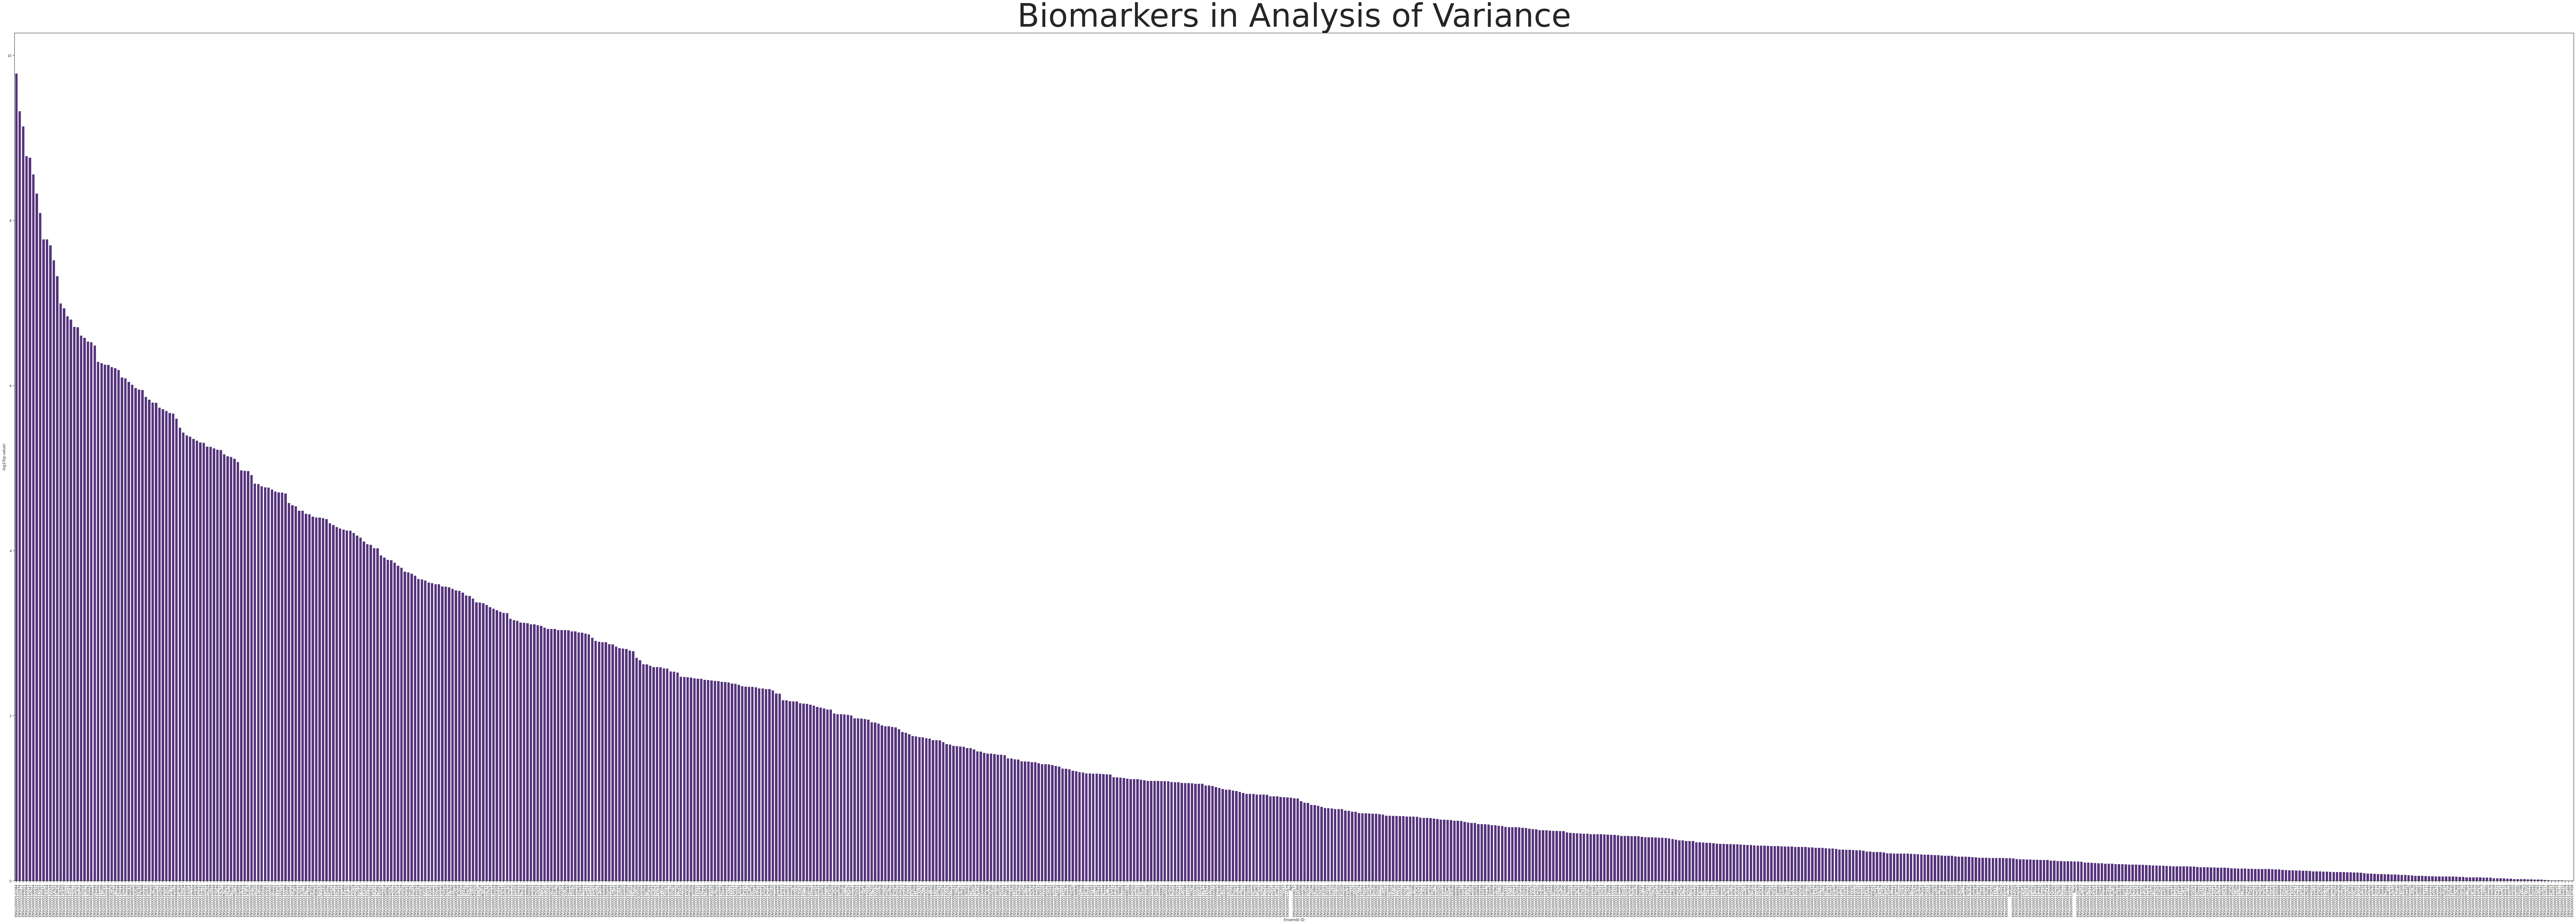

In [20]:
# Figure). Analysis of Variance
sns.set_style("whitegrid")
sns.set_style("ticks") # <--- Seaborn Settings

anova_figure = anova_df_sorted # <--- Figure Information
anova_figure['-log10(p-value)'] = -np.log10(anova_figure['p-value']) # <--- Normalize p-values

plt.figure(figsize=(150, 50)) # <--- Figure Size 
anova_plot = sns.barplot(data = anova_figure, x = "Ensembl ID", y = "-log10(p-value)", color = "#542788")
plt.xticks(rotation = 90) # <--- Vertical Features
plt.title("Biomarkers in Analysis of Variance", fontsize = 105) # <--- Title
plt.show() # <--- Display Figure

In [21]:
# Figure). Biomarker Table
biomarkers_table = significant_biomarkers_df[['Ensembl ID',
                                              'RFE Score',
                                              'Correlation Coefficient','p-value (Pearson Correlation)',
                                              'Chi-Square Statistic','p-value (Chi-Squared Test)',
                                              'F-Statistic','p-value (ANOVA)',]] # <--- Order Statistics 

biomarkers_table.rename(columns={'p-value (ANOVA)': 'p-value (Analysis of Variance)'}, inplace=True) # <--- Rename Statistics

biomarkers_table # <--- Display Figure

#biomarkers_table.to_csv("4A_Feature-Selection-Table_Supported-Biomarkers.csv", index = None)

Ensembl ID  RFE Score  Correlation Coefficient   
104  ENSG00000266422          8                 0.573205  \
110  ENSG00000242574         27                 0.468663   
126  ENSG00000256618          1                -0.498578   
134  ENSG00000265150         10                 0.501749   
145  ENSG00000234745         41                 0.444308   
153  ENSG00000241553         29                 0.437526   
160  ENSG00000256514         13                -0.422351   
161  ENSG00000231389         46                 0.415750   
179  ENSG00000239998         35                 0.437466   
187  ENSG00000234741         42                 0.381093   
189  ENSG00000247596         20                 0.378112   
201  ENSG00000215845         66                 0.318412   
203  ENSG00000269858          5                 0.393315   
252  ENSG00000233276         43                -0.381306   
259  ENSG00000245910         21                 0.290125   
274  ENSG00000227097         53                 0.256310   
283  ENSG00000254999         14                 0.271572   
301  ENSG00000260592         11                 0.314078   

     p-value (Pearson Correlation)  Chi-Square Statistic   
104                   1.422727e-07           6099.039146  \
110                   3.295239e-05           1182.198479   
126                   8.304967e-06            425.057043   
134                   7.121012e-06           5570.193207   
145                   9.238810e-05          21800.548163   
153                   1.214456e-04            967.241151   
160                   2.194047e-04             97.158556   
161                   2.813561e-04           2762.649364   
179                   1.217368e-04            467.715261   
187                   9.577038e-04            250.754169   
189                   1.057660e-03            169.360342   
201                   6.413323e-03            324.041848   
203                   6.311975e-04            199.903685   
252                   9.509177e-04            286.051535   
259                   1.343124e-02            146.302324   
274                   2.976190e-02           3696.999979   
283                   2.102230e-02            105.501496   
301                   7.215015e-03             45.016687   

     p-value (Chi-Squared Test)  F-Statistic  p-value (Analysis of Variance)  
104                0.000000e+00    18.461681                        0.000084  
110               4.509106e-259    17.331401                        0.000130  
126                1.935248e-94    15.446228                        0.000272  
134                0.000000e+00    14.623182                        0.000378  
145                0.000000e+00    13.250337                        0.000666  
153               2.371251e-212    12.825211                        0.000796  
160                6.399216e-23    12.516301                        0.000907  
161                0.000000e+00    12.508201                        0.000910  
179               1.006809e-103    11.287611                        0.001536  
187                1.778382e-56    10.144119                        0.002544  
189                1.020647e-38    10.131465                        0.002558  
201                1.907727e-72     9.419225                        0.003527  
203                2.192047e-45     9.331682                        0.003670  
252                3.605049e-64     6.823535                        0.011974  
259                1.114934e-33     6.440925                        0.014453  
274                0.000000e+00     5.590552                        0.022150  
283                9.482631e-25     5.208093                        0.026955  
301                1.953626e-11     4.491244                        0.039268

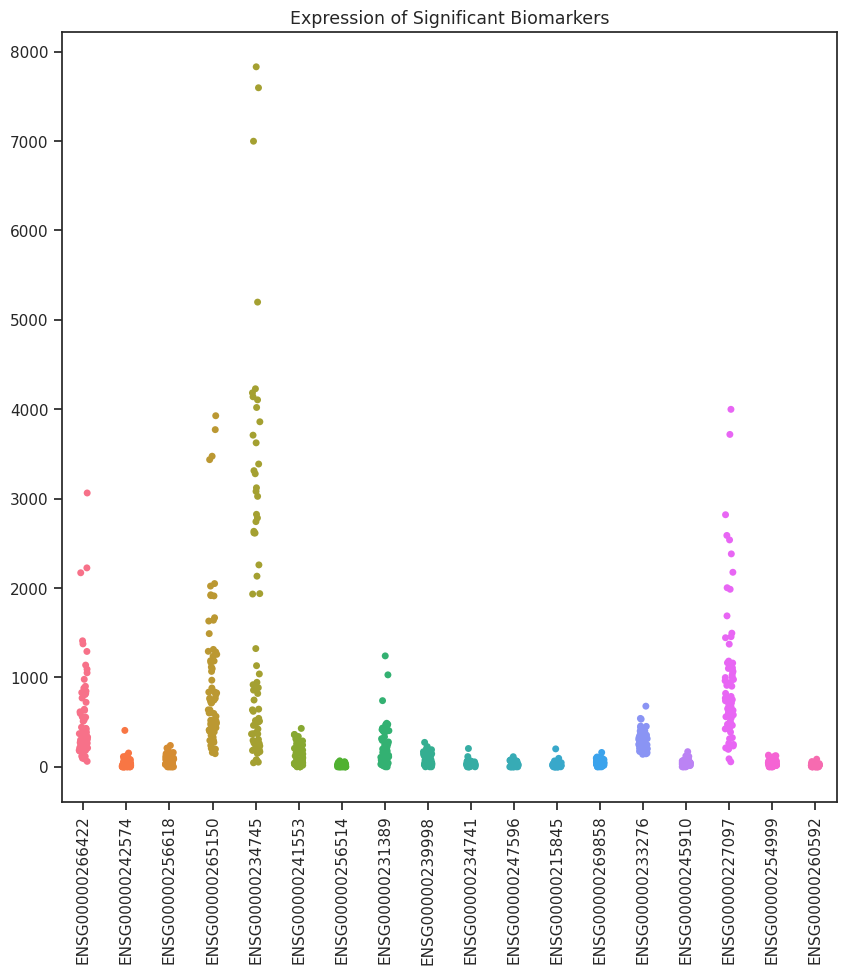

In [22]:
# Figure). Biomarker Expression
sns.set_style("whitegrid")
sns.set_style("ticks") # <--- Seaborn Settings

plt.figure(figsize = (10,10)) # <--- Figure Size 
expression_plot = sns.stripplot(data = df[significant_biomarkers_list]) 
plt.xticks(rotation = 90) # <--- Vertical Features
plt.title("Expression of Significant Biomarkers", fontsize = 12.5) # <--- Title
plt.show() # <--- Display Figure

<Axes: title={'center': 'Absolute Correlations of Significant Biomarkers'}>

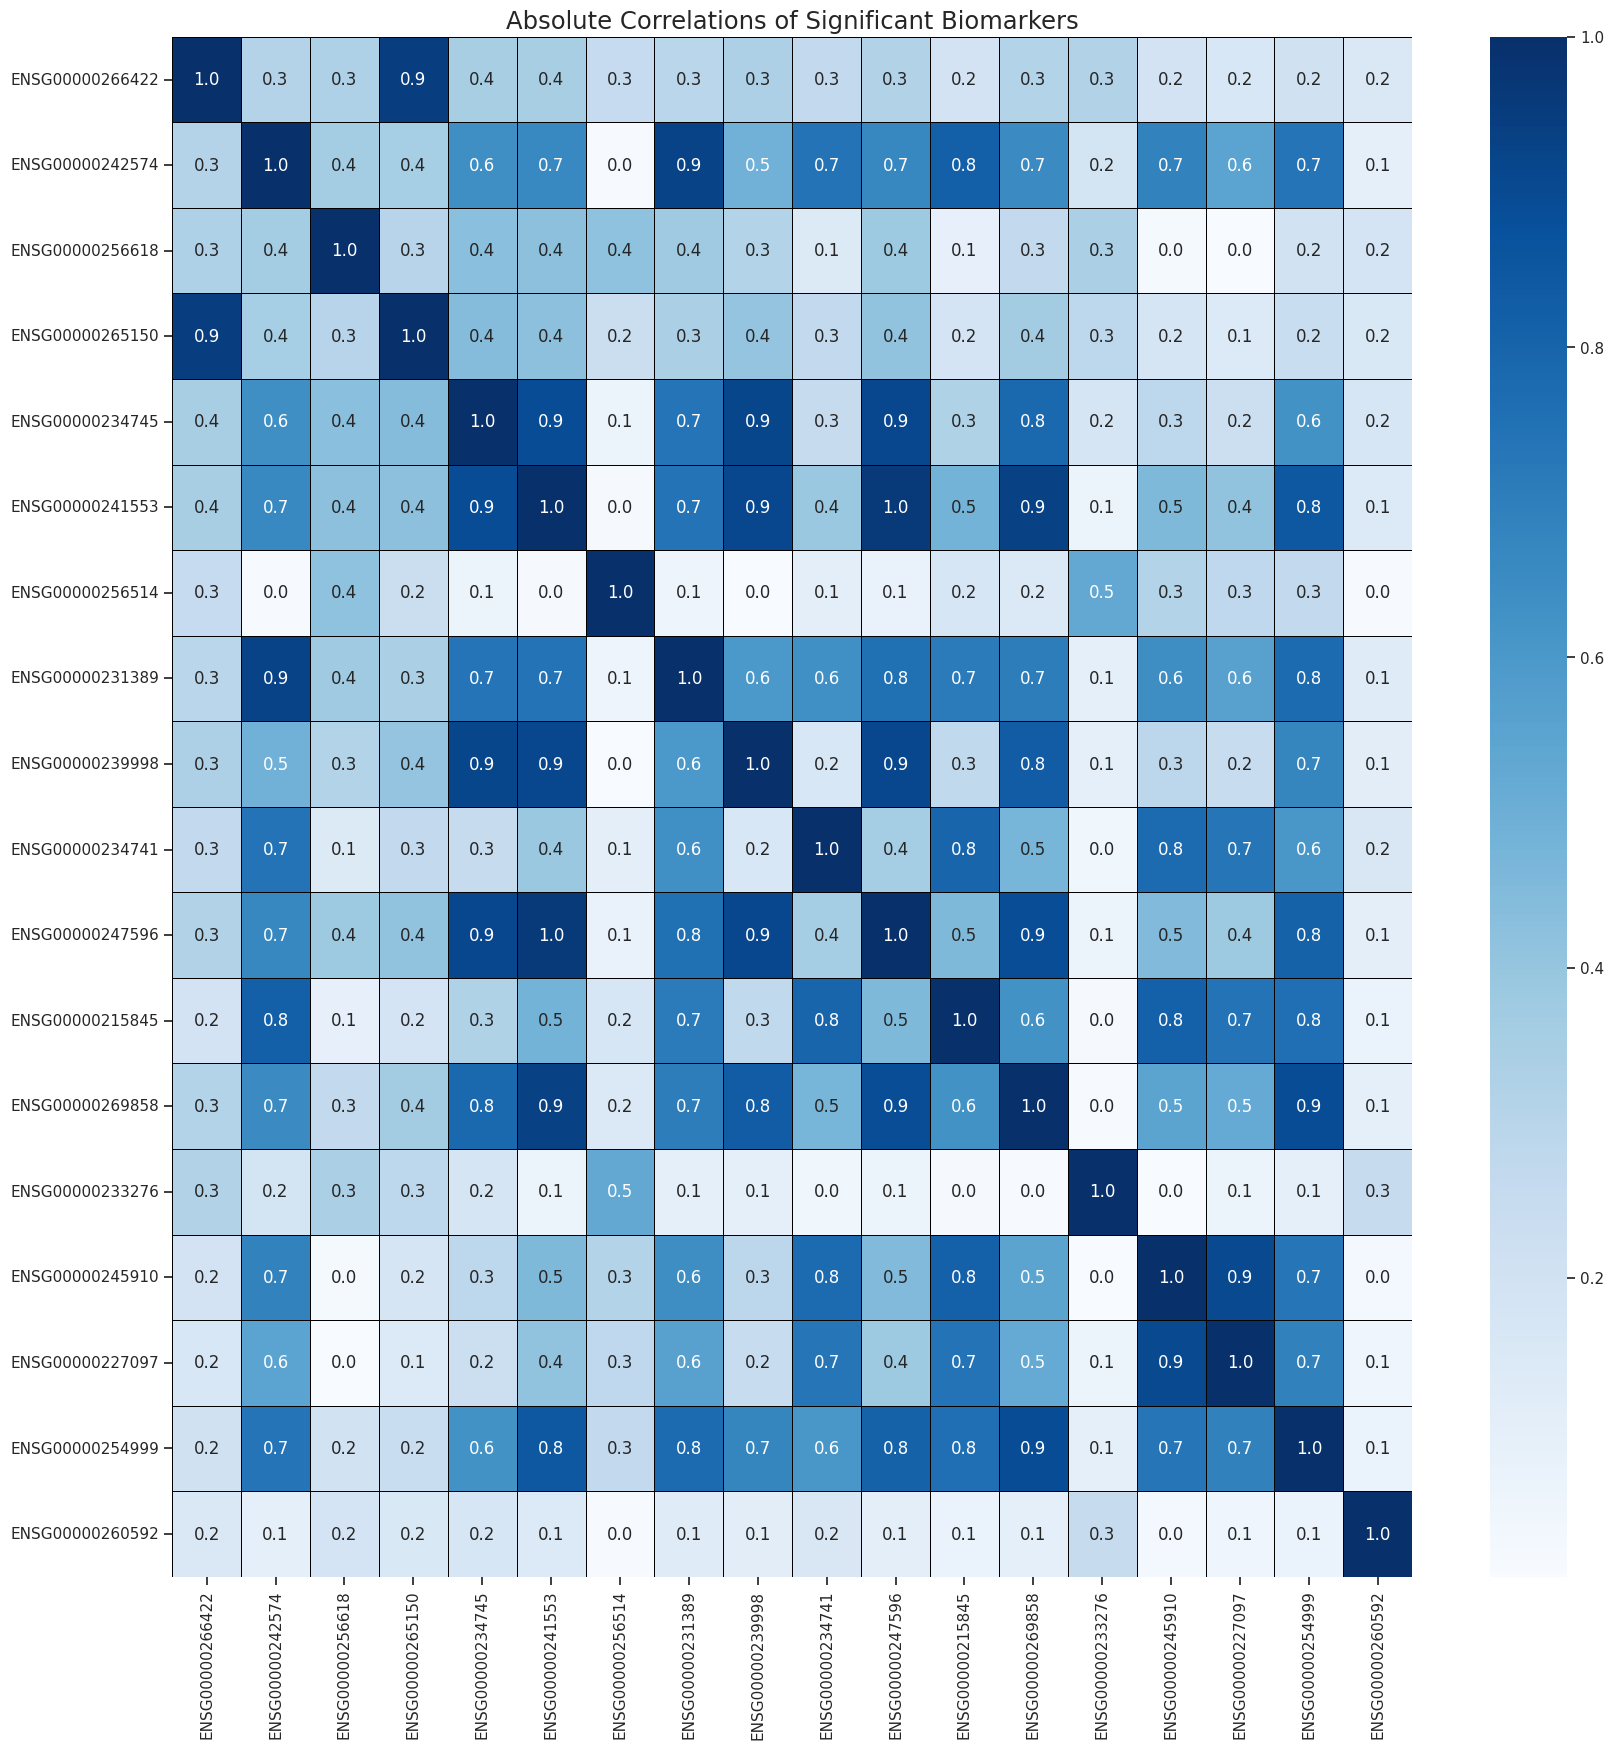

In [23]:
# Figure). Biomarker Correlations
sns.set_style("whitegrid")
sns.set_style("ticks") # <--- Seaborn Settings

correlation_df = df[significant_biomarkers_list]
correlation_matrix = correlation_df.apply(lambda x: pd.to_numeric(x, errors='ignore')) # <--- Figure Information

f, ax = plt.subplots(figsize=(20, 20))  # <--- Figure Size
plt.title("Absolute Correlations of Significant Biomarkers", fontsize = 17.5)  # <--- Title
sns.heatmap(correlation_matrix.corr().abs(),
            annot=True, linewidths=.5, fmt='.1f', ax=ax, linecolor='black', cmap='Blues')  # <--- Display Figure

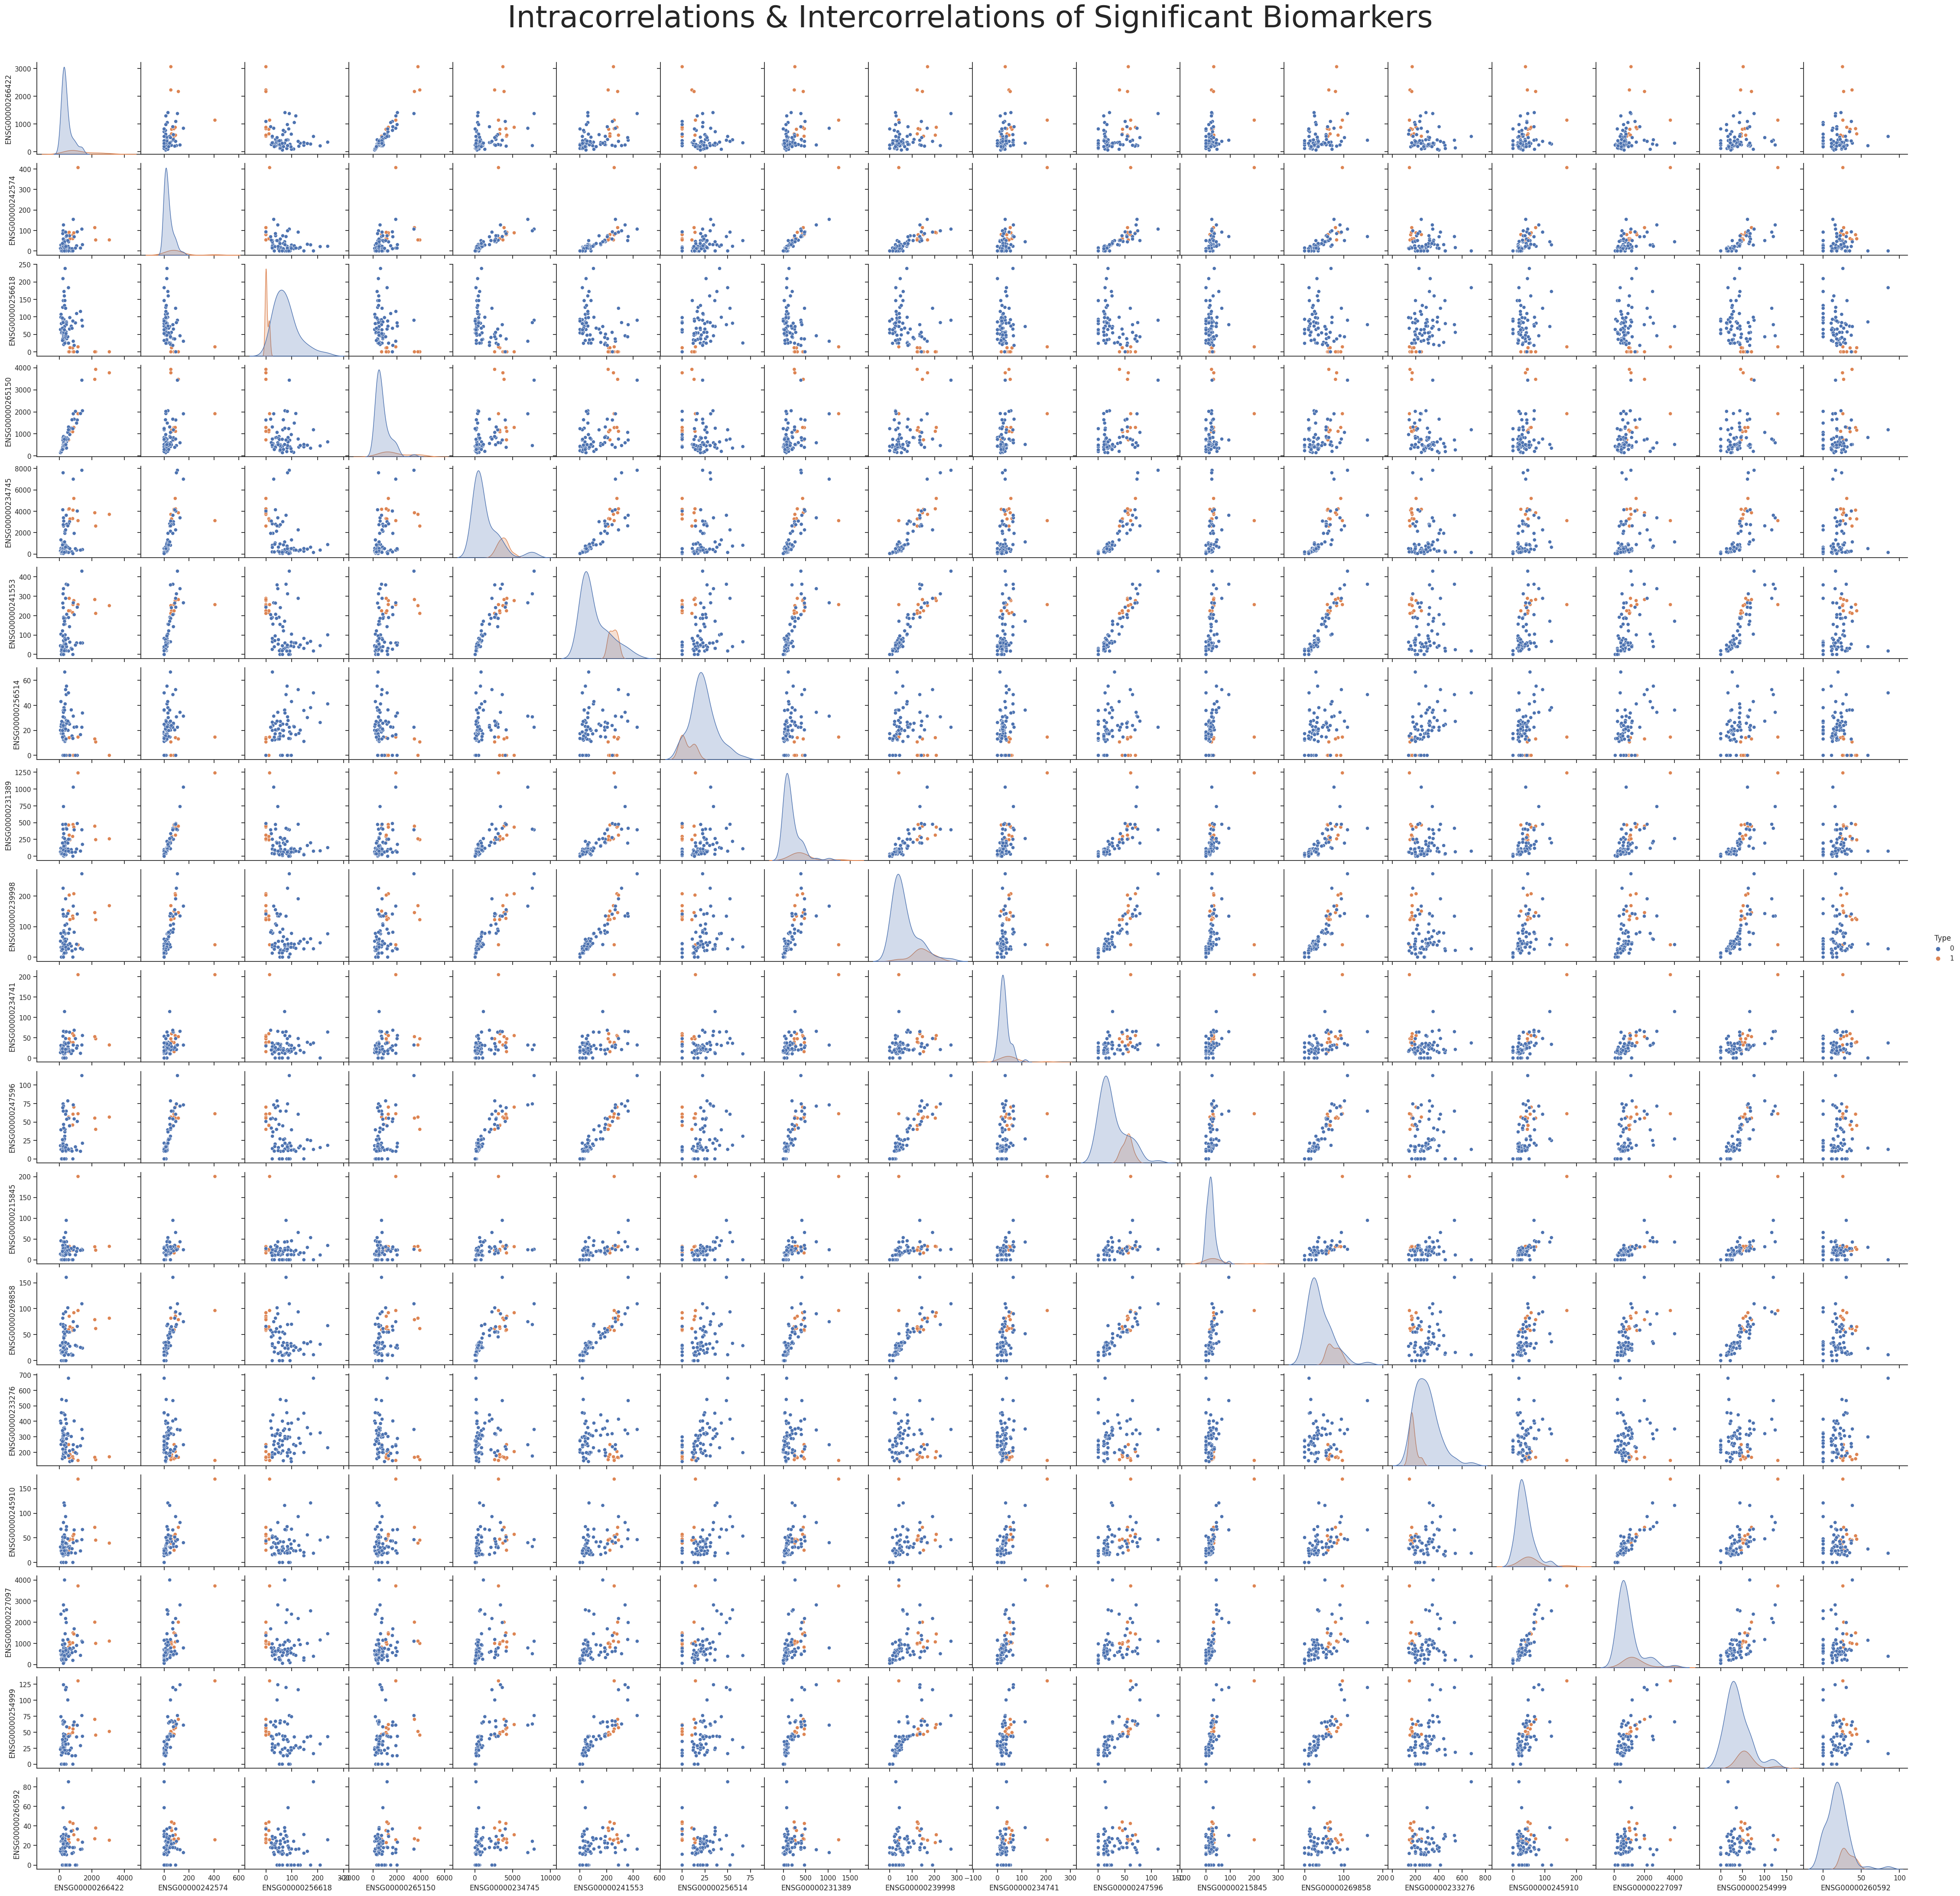

In [24]:
# Figure). Biomarker Pairwise Relationships
sns.set_style("whitegrid")
sns.set_style("ticks") # <--- Seaborn Settings

pairwise_df = df[significant_biomarkers_list] 
pairwise_df = pairwise_df.assign(Type = df['Type'])
pairwise = sns.pairplot(pairwise_df, hue = "Type") # <--- Figure Information

figure = pairwise.fig 
figure.subplots_adjust(top = 0.95, wspace = 0) # <--- Figure Size 
t = figure.suptitle('Intracorrelations & Intercorrelations of Significant Biomarkers', fontsize = 50) # <--- Display Figure

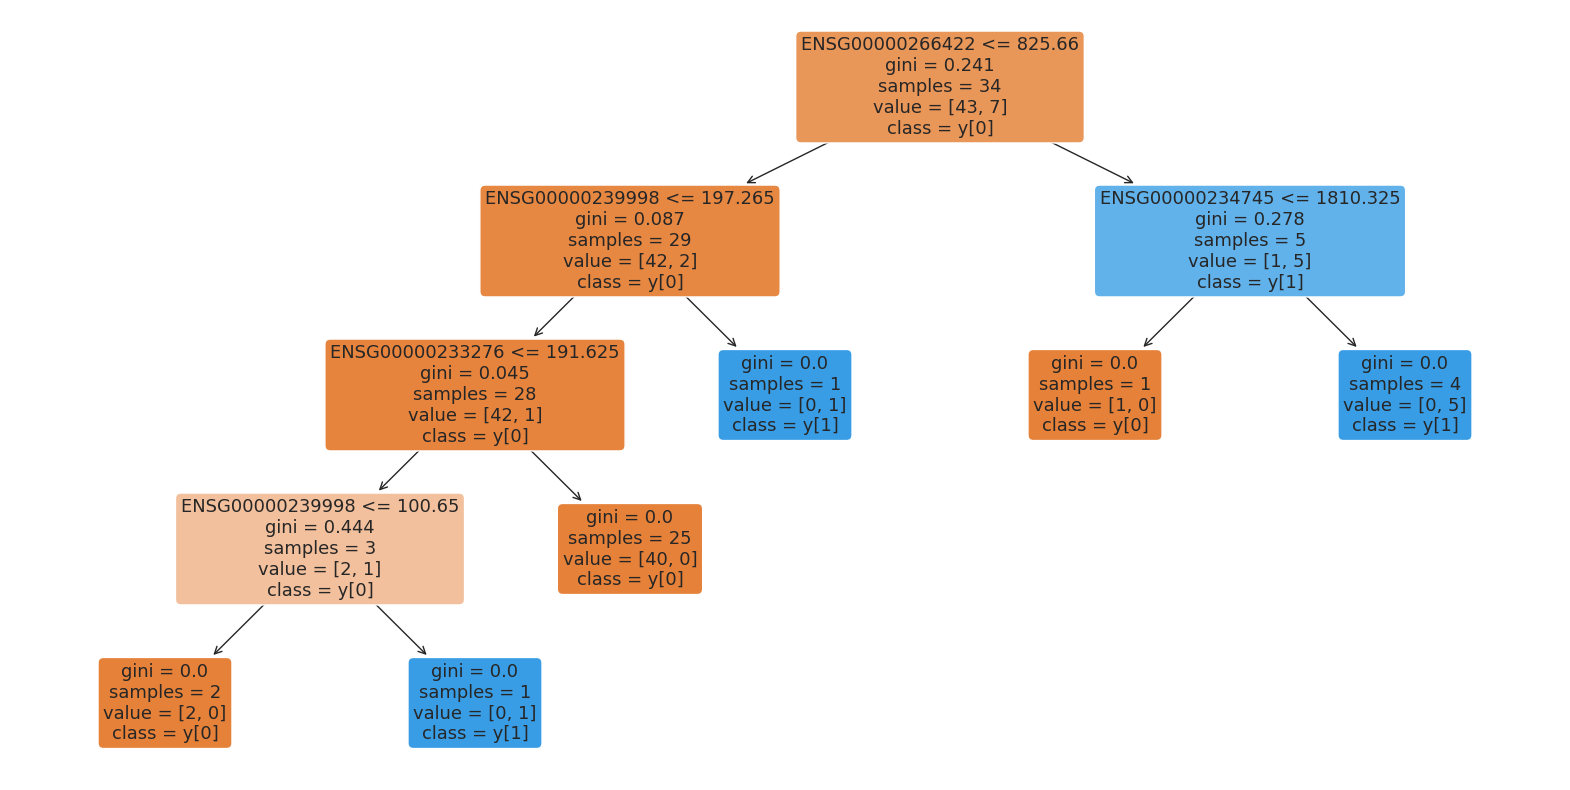

In [25]:
# Figure). Random Forest 
best_tree_index = np.argmax([tree.tree_.max_depth for tree in rf_best.estimators_])
best_tree = rf_best.estimators_[best_tree_index]

plt.figure(figsize=(20, 10)) # <--- Figure Size
plot_tree(best_tree, filled=True, feature_names=x_train.columns, class_names=True, rounded=True) # <--- Best Tree
plt.show() # <--- Display Figure

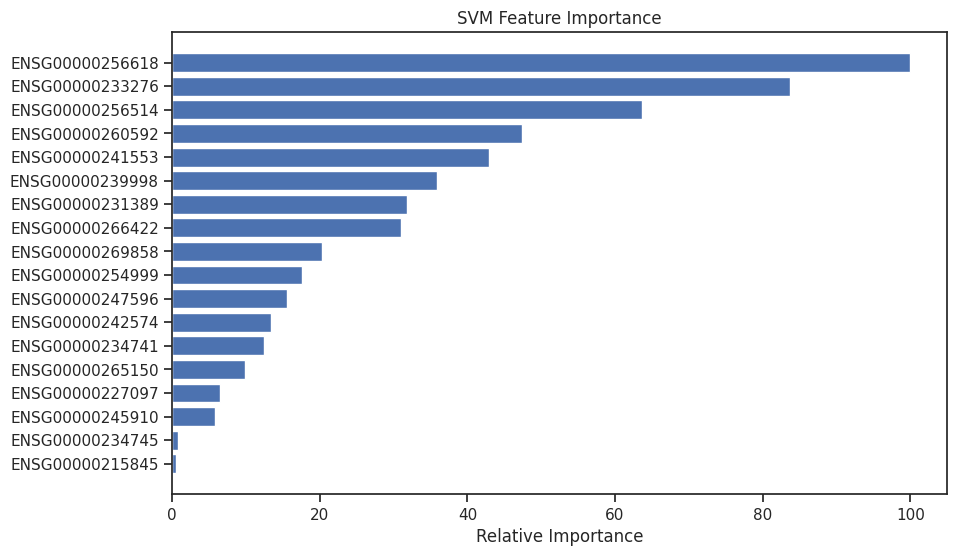

In [26]:
# Figure). Support Vector Machine
def plot_feature_importance(importance, names, model_type):
    feature_importance = np.abs(importance)
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + 0.5
    plt.figure(figsize=(10, 6)) # <--- Figure Size
    plt.barh(pos, feature_importance[sorted_idx], align = 'center')
    plt.yticks(pos, np.array(names)[sorted_idx]) 
    plt.xlabel('Relative Importance')
    plt.title(model_type + ' Feature Importance') # <--- Axes
    plt.show()  #<--- Display Figure

def remove_feature(feature_importance, feature_names, feature_to_remove):
    filtered_importance = [imp for imp, name in zip(feature_importance, feature_names) if name != feature_to_remove]
    filtered_names = [name for name in feature_names if name != feature_to_remove]
    return np.array(filtered_importance), np.array(filtered_names)

if svmc_best.kernel == 'linear':
    importance = svmc_best.coef_[0]
    feature_names = x_train.columns
    feature_to_remove = 'ID'
    filtered_importance, filtered_names = remove_feature(importance, feature_names, feature_to_remove)
    plot_feature_importance(filtered_importance, filtered_names, 'SVM')

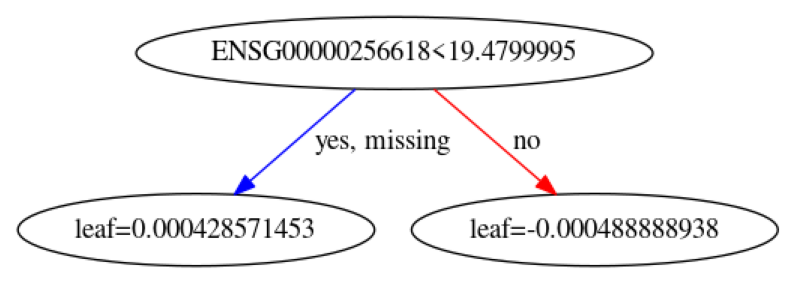

In [27]:
# Figure). XGBoost

xgb_best.fit(x_train, y_train)
ax = xgb.plot_tree(xgb_best, num_trees = 0) # <--- Best Tree

plt.show() # <--- Display Figure

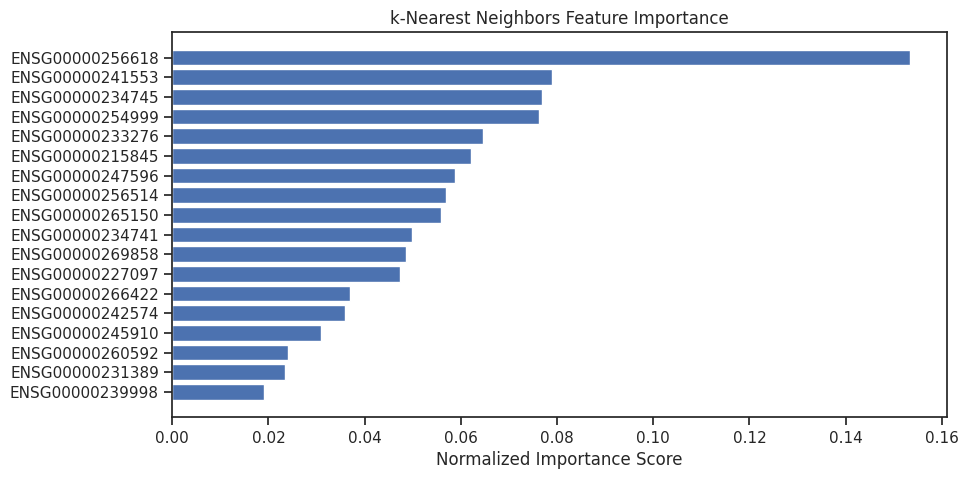

In [28]:
# Figure). k-Nearest Neighbors

feature_importance = mutual_info_classif(x_train, y_train)
normalized_importance = feature_importance / np.sum(feature_importance) 
sorted_idx = np.argsort(normalized_importance)[::-1] # <--- Normalized Feature Importance


plt.figure(figsize=(10, 5)) # <--- Figure Size 
plt.barh(range(x_train.shape[1]), normalized_importance[sorted_idx], align = 'center')
plt.yticks(range(x_train.shape[1]), x_train.columns[sorted_idx])
plt.xlabel('Normalized Importance Score')
plt.title('k-Nearest Neighbors Feature Importance') # <--- Axes
plt.gca().invert_yaxis() # <--- Orientation 
plt.show() # <--- Display Figure

Model Accuracy: 0.9090909090909091


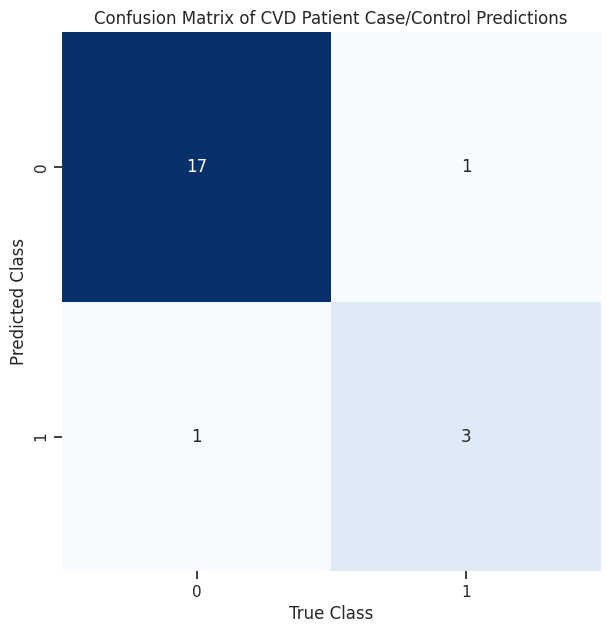

In [29]:
# Figure). Confusion Matrix
figure_size = (7, 7)
figure = plt.figure(figsize = figure_size) # <--- Figure Size

cm = confusion_matrix(y_test, y_predict) # <--- Generate Confusion Matrix
ax = sns.heatmap(cm.T, square = True, annot = True, fmt = 'd', cbar = False, cmap='Blues')

figure_title = 'Confusion Matrix of CVD Patient Case/Control Predictions'
plt.title(figure_title)  # <--- Figure Title
x_label = 'True Class'
plt.xlabel(x_label) # <--- Horizontal Axis Title
y_label = 'Predicted Class'
plt.ylabel(y_label) # <--- Vertical Axis Title

print(f'Model Accuracy: {soft_voting_classifier_accuracy}')
plt.show() # <--- Display Figure

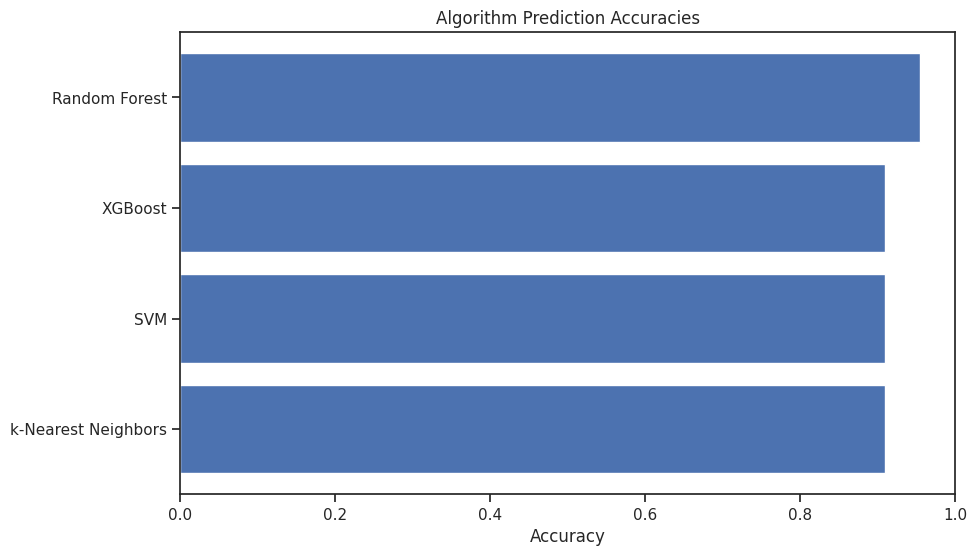

In [30]:
# Figure). Algorithm Accuracies

def plot_algorithm_accuracies(accuracies, algorithm_names, title = 'Algorithm Prediction Accuracies'):
    plt.figure(figsize=(10, 6))
    plt.barh(algorithm_names, accuracies, align = 'center')
    plt.xlabel('Accuracy')
    plt.xlim(0, 1)
    plt.title(title)
    plt.show()

accuracies = [knn_accuracy, xgb_accuracy, svmc_accuracy, rf_accuracy] # <--- Accuracy Variables
algorithms = ['k-Nearest Neighbors', 'SVM', 'XGBoost', 'Random Forest'] # <--- Algorithms 

plot_algorithm_accuracies(accuracies, algorithms) # <--- Display Figure